In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import pickle
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

df = pd.read_parquet("/kaggle/input/taxi-data/yellow_tripdata_2025-01.parquet")

df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2025-01-01 00:18:38,2025-01-01 00:26:59,1.0,1.60,1.0,N,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0
1,1,2025-01-01 00:32:40,2025-01-01 00:35:13,1.0,0.50,1.0,N,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0
2,1,2025-01-01 00:44:04,2025-01-01 00:46:01,1.0,0.60,1.0,N,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0
3,2,2025-01-01 00:14:27,2025-01-01 00:20:01,3.0,0.52,1.0,N,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0
4,2,2025-01-01 00:21:34,2025-01-01 00:25:06,3.0,0.66,1.0,N,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0


In [2]:
df.describe()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,3.475226e+06,3475226,3475226,2.935077e+06,3.475226e+06,2.935077e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,3.475226e+06,2.935077e+06,2.935077e+06
mean,1.785428e+00,2025-01-17 11:02:55.910964,2025-01-17 11:17:56.997901,1.297859e+00,5.855126e+00,2.482535e+00,1.651916e+02,1.641252e+02,1.036623e+00,1.708180e+01,1.317737e+00,4.780991e-01,2.959813e+00,4.493081e-01,9.547946e-01,2.561129e+01,2.225237e+00,1.239111e-01
min,1.000000e+00,2024-12-31 20:47:55,2024-12-18 07:52:40,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-9.000000e+02,-7.500000e+00,-5.000000e-01,-8.600000e+01,-1.269400e+02,-1.000000e+00,-9.010000e+02,-2.500000e+00,-1.750000e+00
25%,2.000000e+00,2025-01-10 07:59:01,2025-01-10 08:15:29.500000,1.000000e+00,9.800000e-01,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.520000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2025-01-17 15:41:33,2025-01-17 15:59:34,1.000000e+00,1.670000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.211000e+01,0.000000e+00,5.000000e-01,2.450000e+00,0.000000e+00,1.000000e+00,1.995000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2025-01-24 19:34:06,2025-01-24 19:48:31,1.000000e+00,3.100000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,1.950000e+01,2.500000e+00,5.000000e-01,3.930000e+00,0.000000e+00,1.000000e+00,2.778000e+01,2.500000e+00,0.000000e+00
max,7.000000e+00,2025-02-01 00:00:44,2025-02-01 23:44:11,9.000000e+00,2.764236e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,8.633721e+05,1.500000e+01,1.050000e+01,4.000000e+02,1.709400e+02,1.000000e+00,8.633804e+05,2.500000e+00,6.750000e+00
std,4.263282e-01,NaN,NaN,7.507503e-01,5.646016e+02,1.163277e+01,6.452948e+01,6.940169e+01,7.013334e-01,4.634729e+02,1.861509e+00,1.374623e-01,3.779681e+00,2.002582e+00,2.781938e-01,4.636585e+02,9.039932e-01,4.725090e-01


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3475226 entries, 0 to 3475225
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee           

In [4]:
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          540149
trip_distance                 0
RatecodeID               540149
store_and_fwd_flag       540149
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     540149
Airport_fee              540149
dtype: int64


In [5]:
# Fill missing passenger_count with median value
df['passenger_count'].fillna(df['passenger_count'].median(), inplace=True)

# Fill missing RatecodeID with most common value (mode)
df['RatecodeID'].fillna(df['RatecodeID'].mode()[0], inplace=True)

# Convert store_and_fwd_flag to numeric (0/1) and fill missing with 'N'
df['store_and_fwd_flag'].fillna('N', inplace=True)
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'Y': 1, 'N': 0})

# Fill missing values in congestion_surcharge and Airport_fee with 0
df['congestion_surcharge'].fillna(0, inplace=True)
df['Airport_fee'].fillna(0, inplace=True)

df.isnull().sum()


<ipython-input-5-f7827041ec7f>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['passenger_count'].fillna(df['passenger_count'].median(), inplace=True)
<ipython-input-5-f7827041ec7f>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
Airport_fee              0
dtype: int64

In [6]:
categorical_cols = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type']
for col in categorical_cols:
    print(f"\n{col} Value Counts:\n", df[col].value_counts())


VendorID Value Counts:
 VendorID
2    2719860
1     753671
7       1206
6        489
Name: count, dtype: int64

RatecodeID Value Counts:
 RatecodeID
1.0     3296621
2.0       94420
99.0      41963
5.0       26501
3.0        8622
4.0        7092
6.0           7
Name: count, dtype: int64

store_and_fwd_flag Value Counts:
 store_and_fwd_flag
0    3467580
1       7646
Name: count, dtype: int64

payment_type Value Counts:
 payment_type
1    2444393
0     540149
2     390429
4      76481
3      23773
5          1
Name: count, dtype: int64


Top 10 Pickup Locations:
 PULocationID
161    169977
237    163703
236    155647
132    146137
230    125829
186    119131
162    117930
142    110585
239     96614
163     95906
Name: count, dtype: int64


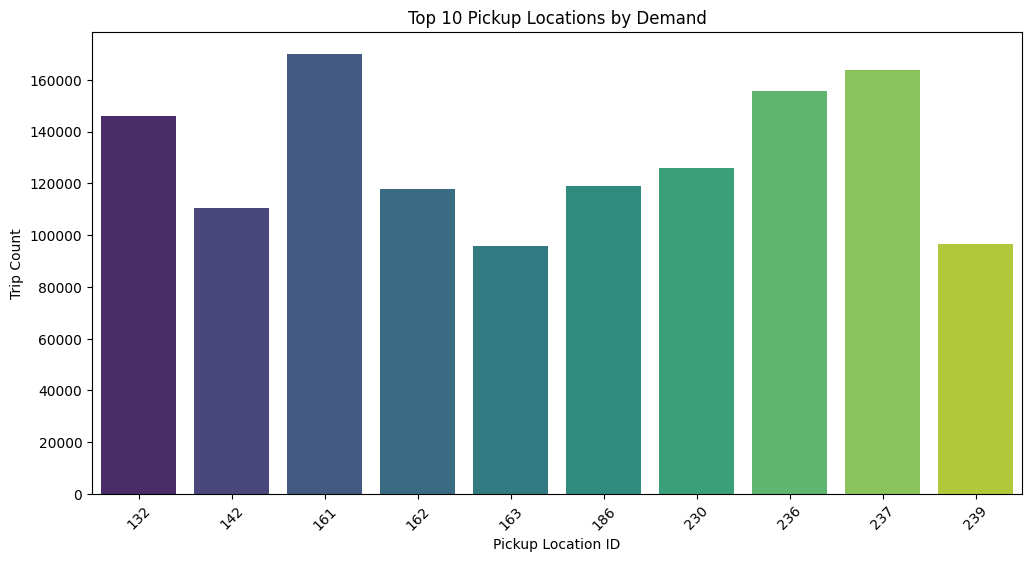

In [7]:
top_locations = df['PULocationID'].value_counts().head(10)
print("Top 10 Pickup Locations:\n", top_locations)

# Bar plot for top 10 locations
plt.figure(figsize=(12, 6))
sns.barplot(x=top_locations.index, y=top_locations.values, palette='viridis')
plt.xlabel("Pickup Location ID")
plt.ylabel("Trip Count")
plt.title("Top 10 Pickup Locations by Demand")
plt.xticks(rotation=45)
plt.show()

In [8]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df.set_index('tpep_pickup_datetime', inplace=True)


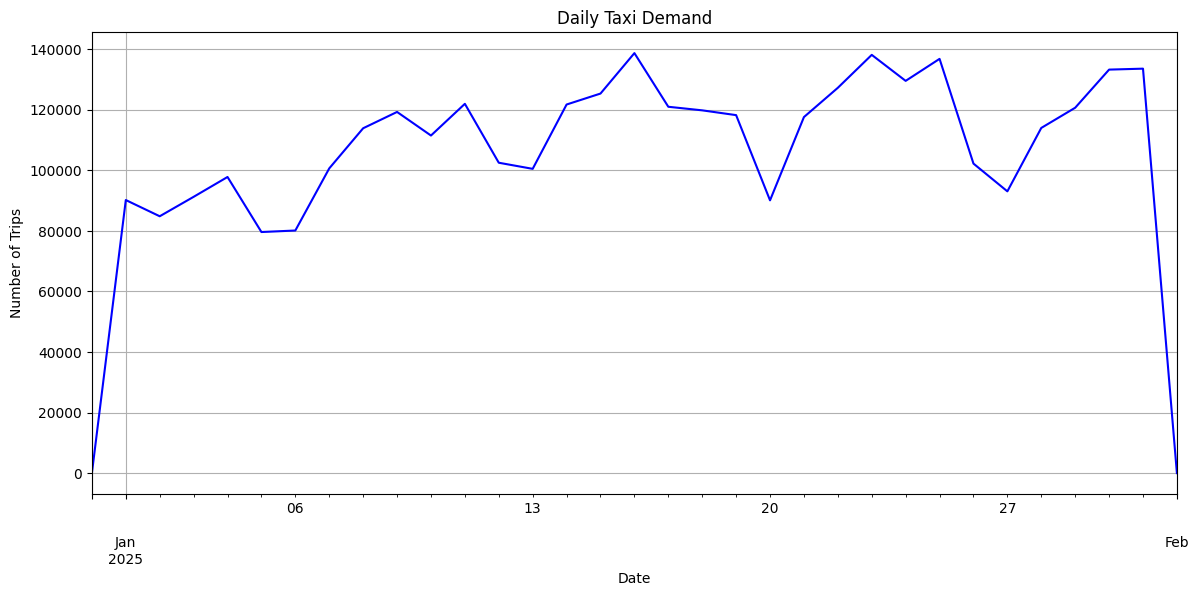

In [9]:
plt.figure(figsize=(14, 6))
df.resample('D').size().plot(title="Daily Taxi Demand", color='blue')
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.grid()
plt.show()


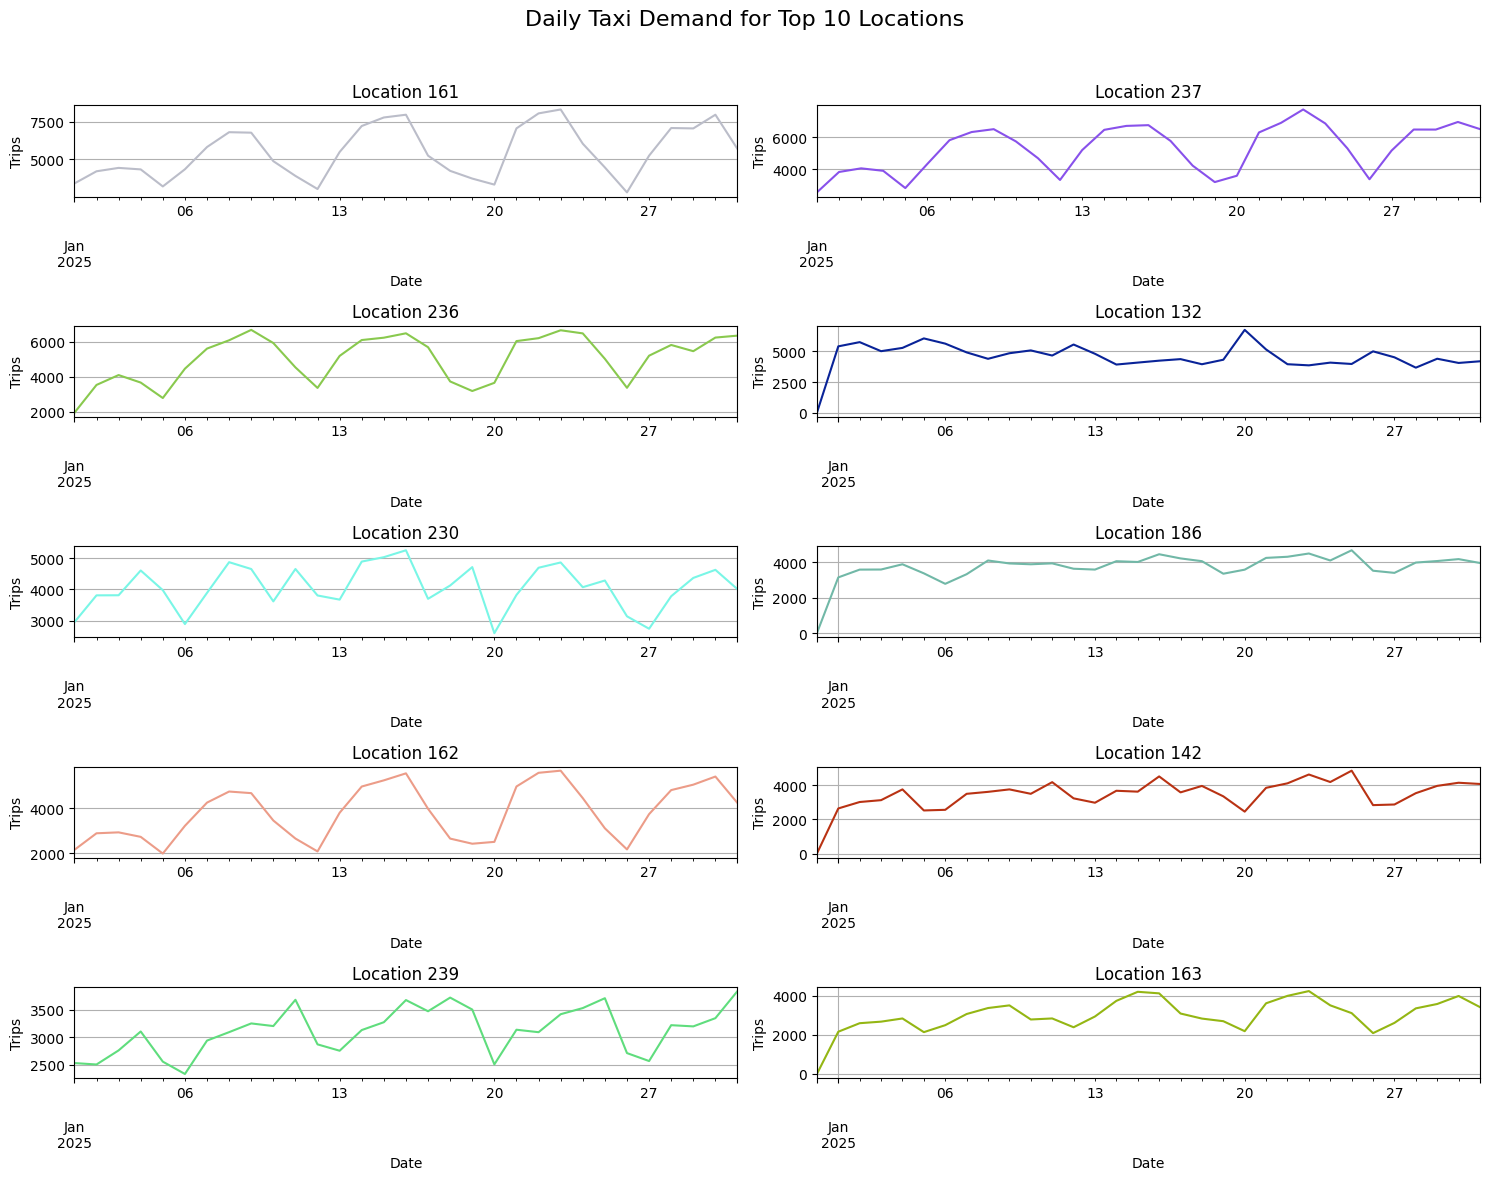

In [10]:
# Plot demand trends for top 10 locations
top_10_locations = top_locations.index

plt.figure(figsize=(15, 12))
for i, loc_id in enumerate(top_10_locations, 1):
    plt.subplot(5, 2, i)
    # Filter data for location
    df_loc = df[df['PULocationID'] == loc_id]
    df_loc.resample('D').size().plot(title=f"Location {loc_id}", color=np.random.rand(3,))
    plt.xlabel("Date")
    plt.ylabel("Trips")
    plt.grid()

plt.suptitle("Daily Taxi Demand for Top 10 Locations", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [11]:
# Remove negative/zero trip distances
df = df[df['trip_distance'] > 0]

# Remove negative fare amounts (some are -900)
df = df[df['fare_amount'] > 0]

# Remove trips with zero passengers
df = df[df['passenger_count'] > 0]

# Set reasonable upper limits for trip distance and fare
df = df[df['trip_distance'] < 100]
df = df[df['fare_amount'] < 500]

In [12]:
df.head()

,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,
2025-01-01 00:18:38,1,2025-01-01 00:26:59,1.0,1.60,1.0,0,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0
2025-01-01 00:32:40,1,2025-01-01 00:35:13,1.0,0.50,1.0,0,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0
2025-01-01 00:44:04,1,2025-01-01 00:46:01,1.0,0.60,1.0,0,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0
2025-01-01 00:14:27,2,2025-01-01 00:20:01,3.0,0.52,1.0,0,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0
2025-01-01 00:21:34,2,2025-01-01 00:25:06,3.0,0.66,1.0,0,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0


In [13]:
# Moves index back to a column
df.reset_index(inplace=True)

In [14]:
df[:5]

,tpep_pickup_datetime,VendorID,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2025-01-01 00:18:38,1,2025-01-01 00:26:59,1.0,1.60,1.0,0,229,237,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.0
1,2025-01-01 00:32:40,1,2025-01-01 00:35:13,1.0,0.50,1.0,0,236,237,1,5.1,3.5,0.5,2.02,0.0,1.0,12.12,2.5,0.0
2,2025-01-01 00:44:04,1,2025-01-01 00:46:01,1.0,0.60,1.0,0,141,141,1,5.1,3.5,0.5,2.00,0.0,1.0,12.10,2.5,0.0
3,2025-01-01 00:14:27,2,2025-01-01 00:20:01,3.0,0.52,1.0,0,244,244,2,7.2,1.0,0.5,0.00,0.0,1.0,9.70,0.0,0.0
4,2025-01-01 00:21:34,2,2025-01-01 00:25:06,3.0,0.66,1.0,0,244,116,2,5.8,1.0,0.5,0.00,0.0,1.0,8.30,0.0,0.0


In [15]:
# Remove records where dropoff is before pickup
df = df[df['tpep_dropoff_datetime'] >= df['tpep_pickup_datetime']]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3229946 entries, 0 to 3230067
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[us]
 1   VendorID               int32         
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     int64         
 7   PULocationID           int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            floa

In [17]:
# Ensure 'tpep_pickup_datetime' is in datetime format
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

# Set as index for resampling
df.set_index('tpep_pickup_datetime', inplace=True)

# Focus on top 10 locations only
top_10_locations = top_locations.index
df_top10 = df[df['PULocationID'].isin(top_10_locations)]

# Resample data to hourly trip counts for ARIMA
df_aggregated = df_top10.resample('h').size().reset_index()
df_aggregated.columns = ['datetime', 'trip_count']

ADF Statistic: -3.0350569339721356
p-value: 0.031747704889779294


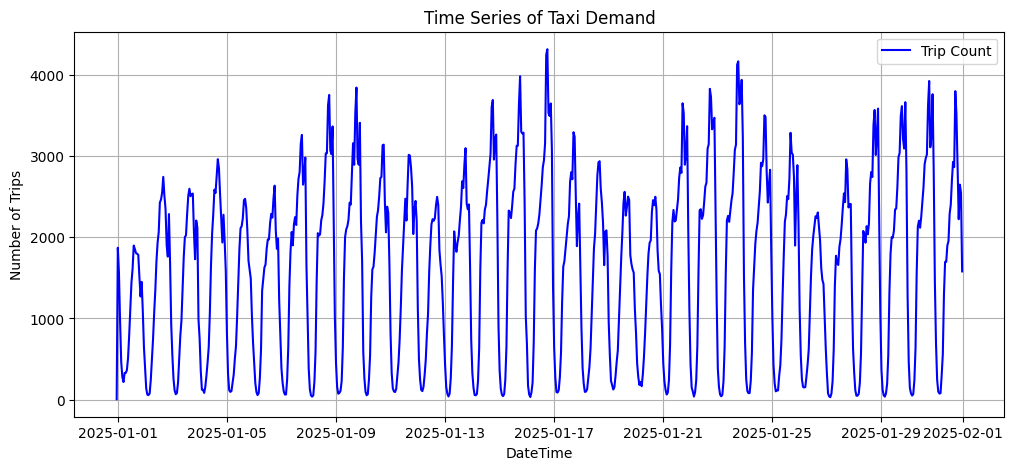

In [18]:
# Perform ADF Test
result = adfuller(df_aggregated['trip_count'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Visualize trip demand
plt.figure(figsize=(12, 5))
plt.plot(df_aggregated['datetime'], df_aggregated['trip_count'], label="Trip Count", color='blue')
plt.title("Time Series of Taxi Demand")
plt.xlabel("DateTime")
plt.ylabel("Number of Trips")
plt.legend()
plt.grid()
plt.show()

In [19]:
df_aggregated['trip_count_diff'] = df_aggregated['trip_count'].diff()

# Drop NaN values that result from differencing
df_aggregated.dropna(subset=['trip_count_diff'], inplace=True)

# Re-run ADF test
from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(df_aggregated['trip_count_diff'])
print("ADF Statistic after differencing:", result_diff[0])
print("p-value after differencing:", result_diff[1])


ADF Statistic after differencing: -14.610902372843114
p-value after differencing: 4.0244003358553375e-27


<Figure size 1200x500 with 0 Axes>

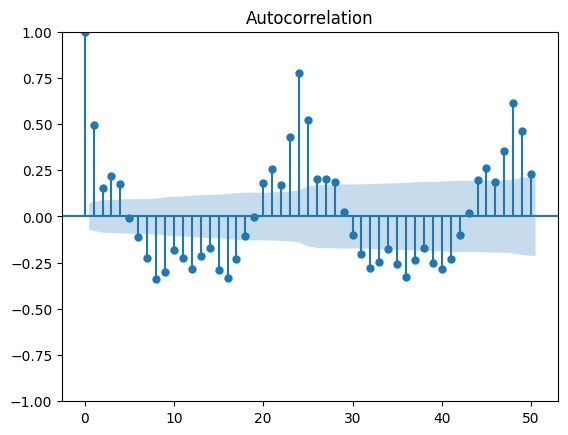

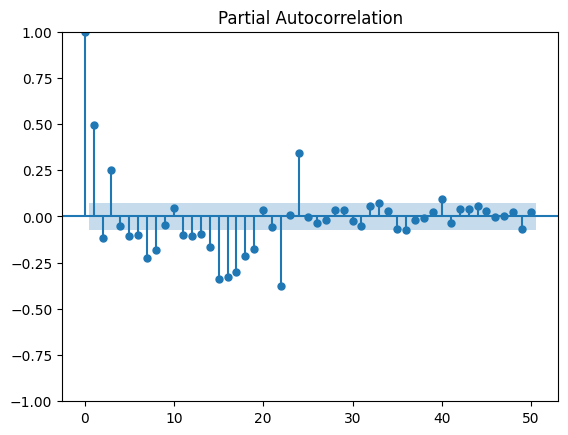

In [20]:
plt.figure(figsize=(12, 5))
plot_acf(df_aggregated['trip_count_diff'].dropna(), lags=50)
plot_pacf(df_aggregated['trip_count_diff'].dropna(), lags=50)
plt.show()

In [21]:
# Define ARIMA model
p, d, q = 2, 1, 2
model_1 = ARIMA(df_aggregated['trip_count'], order=(p, d, q))
arima_result_1 = model_1.fit()

# Print Model Summary
print(arima_result_1.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             trip_count   No. Observations:                  744
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5386.971
Date:                Sun, 06 Apr 2025   AIC                          10783.941
Time:                        09:56:30   BIC                          10806.995
Sample:                             0   HQIC                         10792.828
                                - 744                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5106      0.427      1.195      0.232      -0.327       1.348
ar.L2          0.0941      0.114      0.825      0.409      -0.129       0.318
ma.L1          0.1241      0.430      0.289      0.7

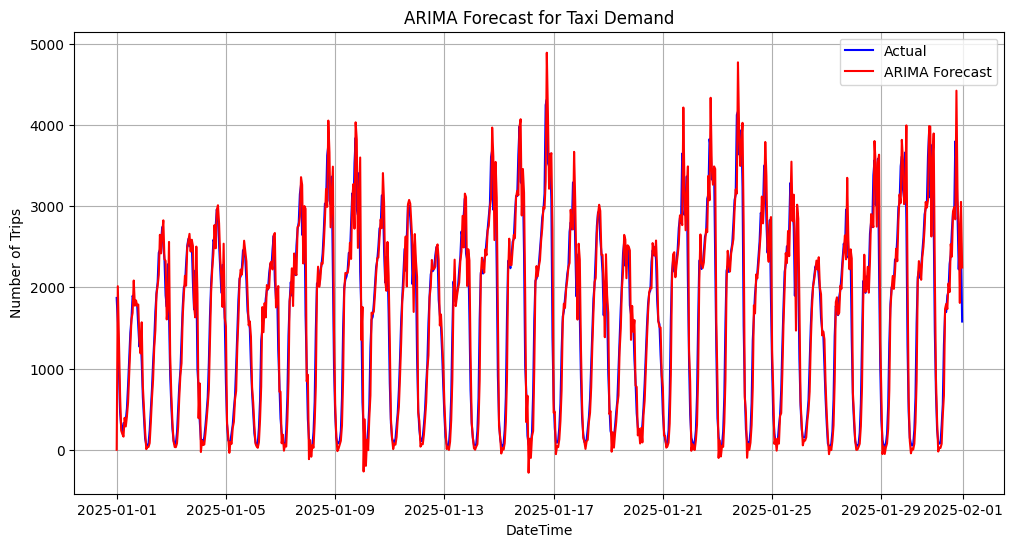

In [22]:
df_aggregated['forecast'] = arima_result_1.predict(start=0, end=len(df_aggregated)-1)

plt.figure(figsize=(12, 6))
plt.plot(df_aggregated['datetime'], df_aggregated['trip_count'], label="Actual", color='blue')
plt.plot(df_aggregated['datetime'], df_aggregated['forecast'], label="ARIMA Forecast", color='red')
plt.xlabel("DateTime")
plt.ylabel("Number of Trips")
plt.title("ARIMA Forecast for Taxi Demand")
plt.legend()
plt.grid()
plt.show()

In [23]:
df = df.reset_index()

In [24]:
# Save the ARIMA model
with open("arima_model.pkl", "wb") as f:
    pickle.dump(arima_result_1, f)

In [25]:

# Save the DataFrame
df_aggregated.to_pickle("arima_data.pkl")


🔹 Processing Location 161
ADF Statistic: -2.8414025009115504, p-value: 0.05259875126870477
Applied differencing for Location 161


<ipython-input-26-ce2bee2559c2>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_location_agg = df_location.resample('H', on='tpep_pickup_datetime').size().reset_index()
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use o

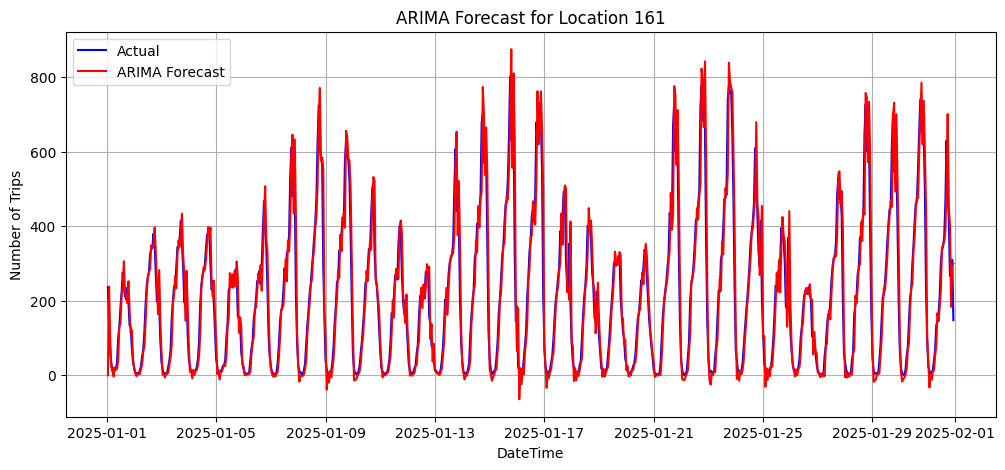


🔹 Processing Location 237
ADF Statistic: -2.6534707146095133, p-value: 0.08244168832375548
Applied differencing for Location 237


<ipython-input-26-ce2bee2559c2>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_location_agg = df_location.resample('H', on='tpep_pickup_datetime').size().reset_index()
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use o

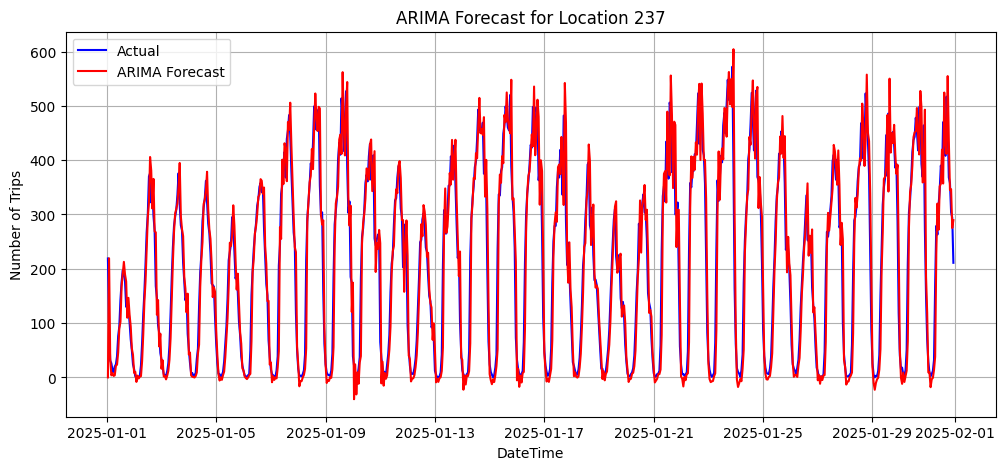


🔹 Processing Location 236
ADF Statistic: -3.2635396299502015, p-value: 0.016589025763170704


<ipython-input-26-ce2bee2559c2>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_location_agg = df_location.resample('H', on='tpep_pickup_datetime').size().reset_index()


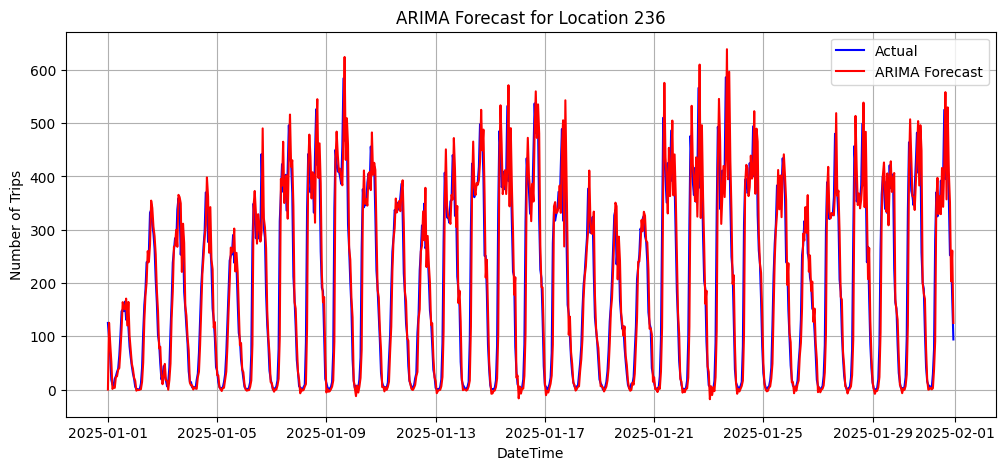


🔹 Processing Location 132
ADF Statistic: -4.212767420923278, p-value: 0.0006268672450462075


<ipython-input-26-ce2bee2559c2>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_location_agg = df_location.resample('H', on='tpep_pickup_datetime').size().reset_index()
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


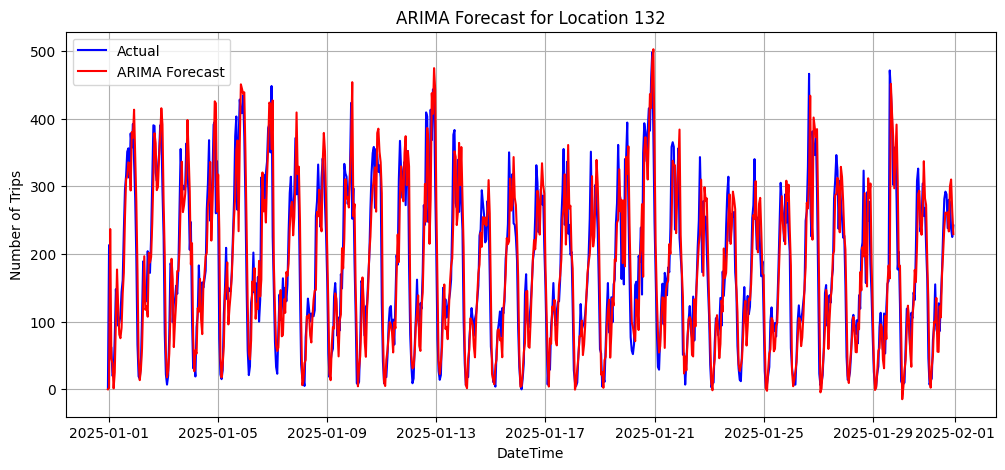


🔹 Processing Location 230
ADF Statistic: -6.341739374254141, p-value: 2.7440469141103652e-08


<ipython-input-26-ce2bee2559c2>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_location_agg = df_location.resample('H', on='tpep_pickup_datetime').size().reset_index()


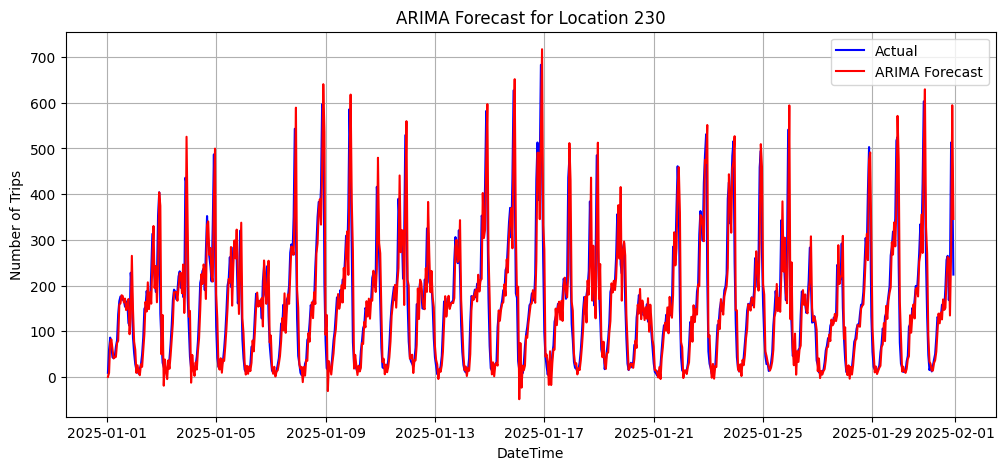


🔹 Processing Location 186
ADF Statistic: -8.23851631040454, p-value: 5.801639448102787e-13


<ipython-input-26-ce2bee2559c2>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_location_agg = df_location.resample('H', on='tpep_pickup_datetime').size().reset_index()
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


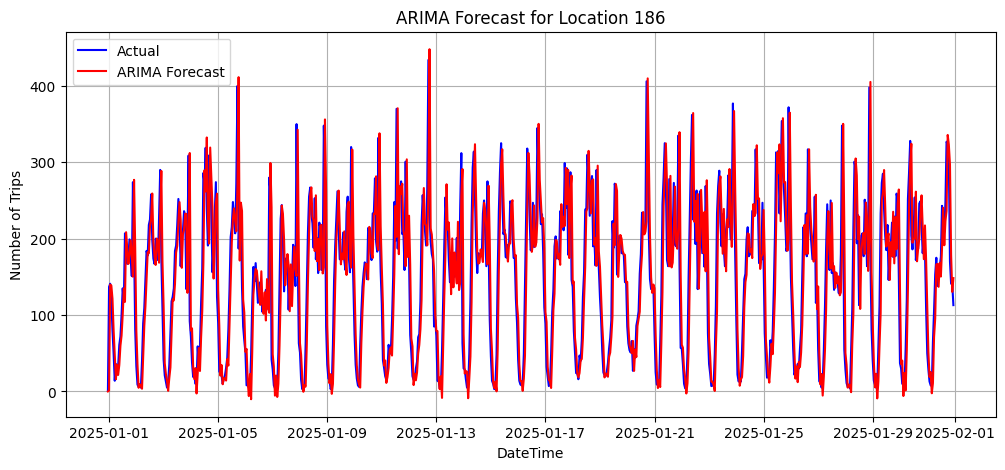


🔹 Processing Location 162
ADF Statistic: -2.5749632705316907, p-value: 0.09828303971629826
Applied differencing for Location 162


<ipython-input-26-ce2bee2559c2>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_location_agg = df_location.resample('H', on='tpep_pickup_datetime').size().reset_index()
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use o

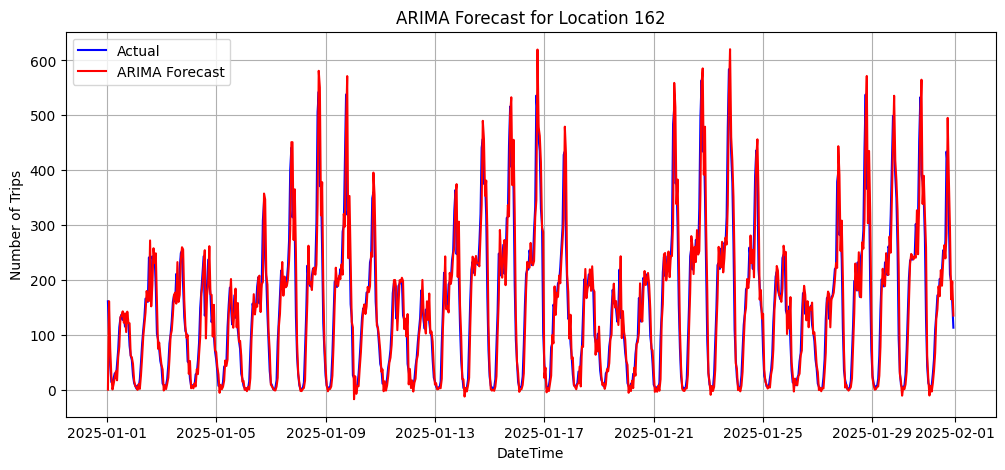


🔹 Processing Location 142
ADF Statistic: -5.967852376565121, p-value: 1.9681952074858672e-07


<ipython-input-26-ce2bee2559c2>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_location_agg = df_location.resample('H', on='tpep_pickup_datetime').size().reset_index()


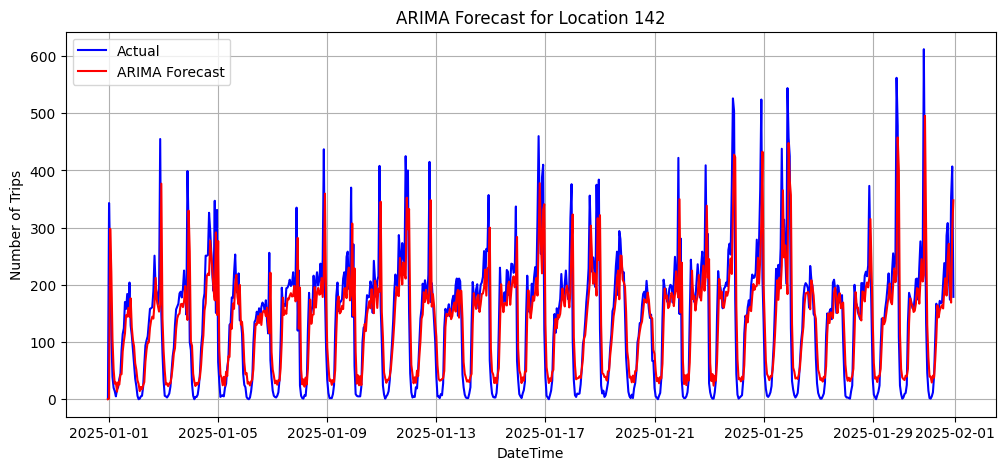


🔹 Processing Location 239
ADF Statistic: -4.929797263189778, p-value: 3.0504207475992683e-05


<ipython-input-26-ce2bee2559c2>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_location_agg = df_location.resample('H', on='tpep_pickup_datetime').size().reset_index()


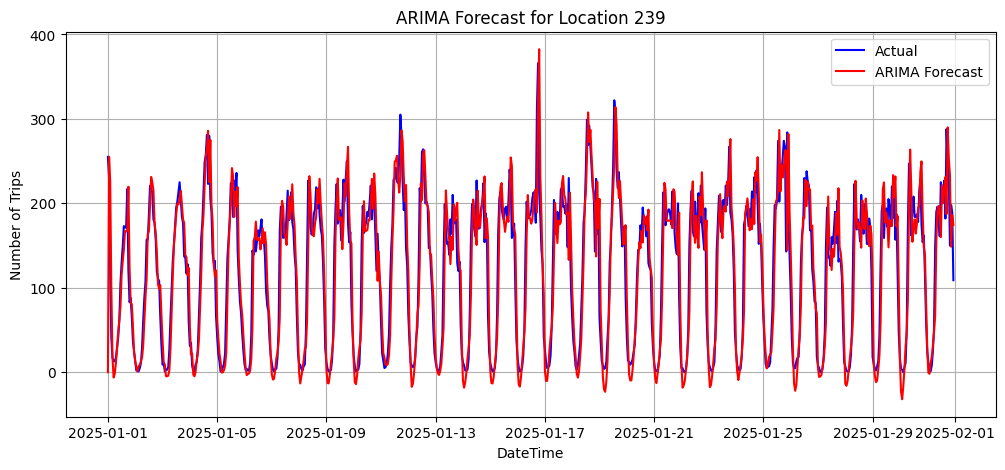


🔹 Processing Location 163
ADF Statistic: -3.4850686634695323, p-value: 0.008378945625769862


<ipython-input-26-ce2bee2559c2>:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_location_agg = df_location.resample('H', on='tpep_pickup_datetime').size().reset_index()


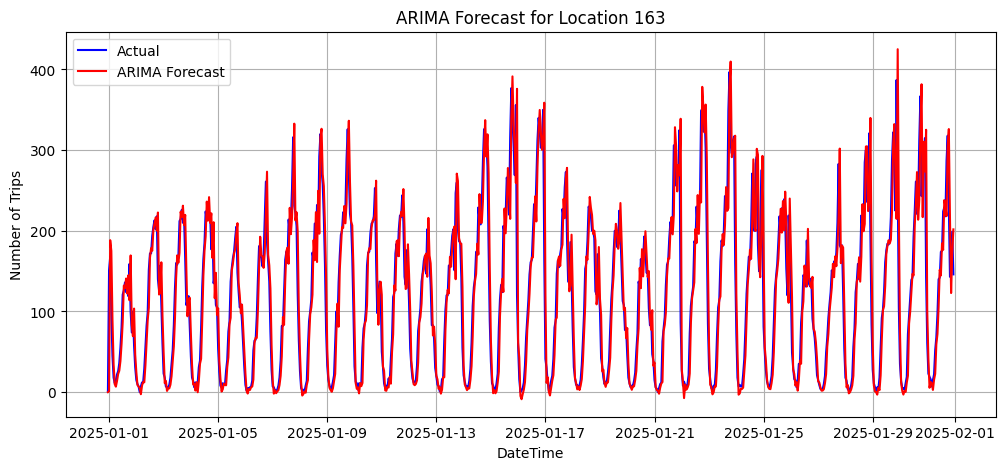

In [26]:
# Iterate over each of the top 10 locations
for location_id in top_locations.index:
    print(f"\n🔹 Processing Location {location_id}")

    # Filter data for the specific location
    df_location = df[df['PULocationID'] == location_id]

    # Aggregate by hour
    df_location_agg = df_location.resample('H', on='tpep_pickup_datetime').size().reset_index()
    df_location_agg.columns = ['datetime', 'trip_count']

    # ADF Test for stationarity
    result = adfuller(df_location_agg['trip_count'])
    print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")

    # Apply differencing if needed
    if result[1] >= 0.05:
        df_location_agg['trip_count_diff'] = df_location_agg['trip_count'].diff()
        df_location_agg.dropna(inplace=True)
        print(f"Applied differencing for Location {location_id}")

    # Train ARIMA Model (use fixed p, d, q or tune it per location)
    p, d, q = 2, 1, 2
    model = ARIMA(df_location_agg['trip_count'], order=(p, d, q))
    arima_result = model.fit()

    # Predict
    df_location_agg['forecast'] = arima_result.predict(start=0, end=len(df_location_agg)-1)

    # Plot Actual vs Predicted
    plt.figure(figsize=(12, 5))
    plt.plot(df_location_agg['datetime'], df_location_agg['trip_count'], label="Actual", color='blue')
    plt.plot(df_location_agg['datetime'], df_location_agg['forecast'], label="ARIMA Forecast", color='red')
    plt.xlabel("DateTime")
    plt.ylabel("Number of Trips")
    plt.title(f"ARIMA Forecast for Location {location_id}")
    plt.legend()
    plt.grid()
    plt.show()
